In [1149]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
palette = sns.color_palette("husl", 8)
colours = [palette[i] for i in range(len(palette))]
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [15]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    
    df.rename(columns={'expected_arrival':'time_of_arrival'}, inplace=True)
    df = df.sort_values(by='time_of_arrival', ignore_index=True)
    return df

In [16]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [17]:
for route in routes:
    add_extra_data(route)

In [18]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [1150]:
new_6 = pd.read_csv("data/6 09-06-20.csv")
new_52 = pd.read_csv("data/52 09-06-20.csv")
new_9 = pd.read_csv("data/9 09-06-20.csv")

new_6.head()

,vehicle_id,bus_stop_id,time_of_arrival,time_of_req,direction
0,10623_490003256N_2020-05-17_inbound_0,490003256N,2020-05-17 17:19:04,2020-05-17 17:19:17.892,inbound
1,10623_490006108E_2020-05-17_inbound_0,490006108E,2020-05-17 17:20:01,2020-05-17 17:19:24.951,inbound
2,10636_490006471E_2020-05-17_outbound_0,490006471E,2020-05-17 17:19:30,2020-05-17 17:19:27.03,outbound
3,10285_490013046M_2020-05-17_outbound_0,490013046M,2020-05-17 17:19:58,2020-05-17 17:19:36.662,outbound
4,11485_490000186A_2020-05-17_inbound_0,490000186A,2020-05-17 17:20:09,2020-05-17 17:19:37.928,inbound


In [19]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

In [1158]:
stops_452 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_452.csv")
stops_52 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_52.csv")
stops_7 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_7.csv")
stops_14 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_14.csv")
stops_9 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_9.csv")
stops_328 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_328.csv")
stops_69 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_69.csv")
stops_35 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_35.csv")
stops_37 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_37.csv")
stops_267 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_267.csv")
stops_277 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_277.csv")
stops_6 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_6.csv")

stops = {}
stops["452"] = stops_452
stops["52"] = stops_52
stops["7"] = stops_7
stops["9"] = stops_9
stops["14"] = stops_14
stops["328"] = stops_328
stops["267"] = stops_267
stops["277"] = stops_277
stops["35"] = stops_35
stops["37"] = stops_37
stops["69"] = stops_69
stops["6"] = stops_6

## Helper Functions

In [20]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [21]:
def weekday_or_weekend(given_day):
    if given_day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
        return "weekday"
    else:
        return "weekend"

In [1153]:
def pre_lockdown(given_time):
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    
    # lockdown = began March 24th 2020, eased up 31st May 2020
    if (month > 3) and (month < 6):
        return False
    elif month == 3:
        if day >= 24:
            return False
    
    return True

In [1154]:
def get_attrs(gap, stop_a, stop_b, a_id):
    start = time.time()
    
    # if gap == 5:
    min_time = 0
    max_time = 15
    
    if (gap > 5) and (gap <= 10):
        min_time = 5
        max_time = 30
    elif (gap > 10) and (gap <= 15):
        min_time = 15
        max_time = 40
    elif (gap > 15) and (gap <= 20):
        min_time = 20
        max_time = 50
    elif (gap > 20) and (gap <= 25):
        min_time = 35
        max_time = 65
    elif (gap > 25) and (gap <= 30):
        min_time = 40
        max_time = 75
    elif (gap > 30):
        min_time = 40
        max_time = 90

    attributes = []
    for i, journey in stop_b.iterrows():

        arr_dt = convert_time_to_datetime(journey['time_of_arrival'])
        [bus_id, _, date, direction, _] = journey['vehicle_id'].split('_')
        to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'

        for j, match in stop_a.iterrows():
            if match['vehicle_id'].startswith(to_match_id):
                leave_dt = convert_time_to_datetime(match['time_of_arrival'])
                journey_time = arr_dt - leave_dt

                if (journey_time > dt.timedelta(minutes = min_time)) & (journey_time < dt.timedelta(minutes = max_time)):
                    item = []
                    item.append(journey_time)

                    seconds = journey_time.total_seconds()
                    item.append(seconds)

                    d = dt.datetime.strptime(match['time_of_arrival'][:10], '%Y-%m-%d')
                    d = calendar.day_name[d.weekday()]
                    w = weekday_or_weekend(d)
                    item.append(w)

                    t = int(journey['time_of_arrival'][11:13])
                    item.append(t)

                    c = pre_lockdown(journey['time_of_arrival'])
                    item.append(c)
                    
                    item.append(gap)
                    item.append(match['time_of_arrival'])
                    item.append(journey['time_of_arrival'])

                    attributes.append(item)
                    break

    print("Getting journey times took {}".format(time.time() - start))
    
    return attributes

In [393]:
# Generate list of request times at minutes interval
def generate_request_times(minutes, start, end):
    """
    minutes: frequency of request times e.g. every 15 minutes
    start: start time
    end: end time
    num_times: the number of times to generate
    """
    start = convert_time_to_datetime(start)
    end = convert_time_to_datetime(end)
    req_times = [start]
    
    while start <= end:
        new_time = start + dt.timedelta(minutes = minutes)
        req_times.append(new_time)
        start = new_time
        
    format = '%Y-%m-%d %H:%M:%S'
    req_times_str = [t.strftime(format) for t in req_times]
    return req_times_str

## Data Preprocessing

In [1164]:
inbound_6 = stops["6"].loc[stops['6']['direction'] == 'inbound']

inbound_6['stop_name'] = pd.Categorical(inbound_6['stop_name'], stops_in_sequence_inbound.get('6'))
inbound_6 = inbound_6.sort_values('stop_name').reset_index()

inbound_52 = stops["52"].loc[stops['52']['direction'] == 'inbound']

inbound_52['stop_name'] = pd.Categorical(inbound_52['stop_name'], stops_in_sequence_inbound.get('52'))
inbound_52 = inbound_52.sort_values('stop_name').reset_index()

inbound_6.head()

/Users/serenechongtrakul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/serenechongtrakul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,stop_id,stop_name,direction
0,16,490003193R,Aldwych / Somerset House,inbound
1,59,490011938U,Savoy Street,inbound
2,14,490003112J,Bedford Street,inbound
3,68,490013766H,Charing Cross Station,inbound
4,70,490013767S,Trafalgar Square,inbound


(1451, 5)


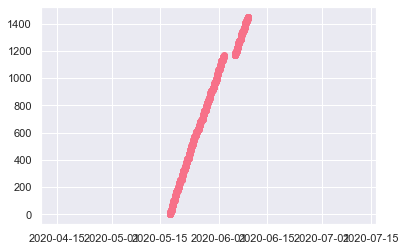

In [1165]:
b_52 = new_6
stop_b52 = b_52.loc[(b_52['bus_stop_id'] == '490013766H') & (b_52['direction'] == 'inbound')]
print(stop_b52.shape)
fig, ax = plt.subplots()
x = [convert_time_to_datetime(i) for i in stop_b52['time_of_arrival']]
ax.scatter(x, [i for i in range(0, len(x))])
# ax.set_xlim([dt.datetime(2020, 4, 15, 2), dt.datetime(2020, 5, 10, 22, 59, 59)])
plt.show()

(1290, 5)


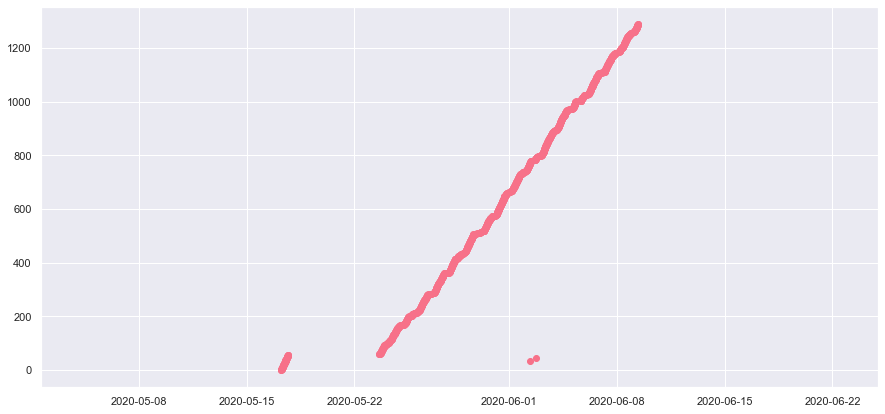

In [1167]:
b_52 = new_52
stop_b52 = b_52.loc[(b_52['bus_stop_id'] == '490014687E') & (b_52['direction'] == 'inbound')]
print(stop_b52.shape)
fig, ax = plt.subplots(figsize=(15,7))
x = [convert_time_to_datetime(i) for i in stop_b52['time_of_arrival']]
ax.scatter(x, [i for i in range(0, len(x))])
# ax.set_xlim([dt.datetime(2020, 4, 15, 2), dt.datetime(2020, 5, 10, 22, 59, 59)])
plt.show()

Pick 2 stops on a route. Calculate all the journey times between them. Make a dataset with attributes time of day (split into hour slots), journey time, day of week, pre lockdown.

Choose multiple 2 stops. Routes 6 and 52 are 24 hour buses. Route 277 doesn't run through zone 1.

1) gap of 5: Willesden Bus Garage -> Okehampton Road route 52

2) gap of 10: Willesden Bus Garage -> Harrow Road / Kilburn Lane route 52

3) gap of 15: Willesden Bus Garage -> Chesterton Road route 52

4) gap of 20: Willesden Bus Garage -> Notting Hill Gate Station route 52

5) gap of 25: Willesden Bus Garage -> Palace Gate route 52

6) gap of 30: Willesden Bus Garage -> Knightsbridge Station  / Harrods route 52

7) gap of 35: Willesden Bus Garage -> Victoria Bus Station route 52

8) gap of 5: Charing Cross Station -> Green Park Station route 6

9) gap of 10: Charing Cross Station -> Marble Arch / Edgware Road route 6

10) gap of 15: Charing Cross Station -> Orchardson Street route 6

11) gap of 20: Charing Cross Station -> Elgin Avenue route 6

12) gap of 25: Charing Cross Station -> Fernhead Road route 6

13) gap of 30: Charing Cross Station -> Wrentham Avenue route 6

14) gap of 35: Charing Cross Station -> Clare Road route 6

15) gap of 5: Crossharbour Asda -> St Edmund's School route 277

16) gap of 10: Crossharbour Asda -> Byng Street route 277

17) gap of 15: Crossharbour Asda -> Canary Wharf Station route 277

18) gap of 20: Crossharbour Asda -> East India Dock Road route 277

19) gap of 25: Crossharbour Asda -> Mile End Station route 277

20) gap of 30: Crossharbour Asda -> Old Ford Road route 277

21) gap of 35: Crossharbour Asda -> Holcroft Road route 277

In [348]:
stop_as = ["Willesden Bus Garage" for i in range(0, 7)] +  ["Charing Cross Station" for i in range(0, 7)] + ["Crossharbour Asda" for i in range(0, 7)]
stop_bs = ["Okehampton Road", "Harrow Road / Kilburn Lane", "Chesterton Road", "Notting Hill Gate Station", "Palace Gate", "Knightsbridge Station  / Harrods", "Victoria Bus Station"]
stop_bs = stop_bs + ["Green Park Station", "Marble Arch / Edgware Road", "Orchardson Street", "Elgin Avenue", "Fernhead Road", "Wrentham Avenue", "Clare Road"]
stop_bs = stop_bs + ["St Edmund's School", "Byng Street", "Canary Wharf Station", "East India Dock Road", "Mile End Station", "Old Ford Road", "Holcroft Road"]
route_ids = ["52" for i in range(0, 7)] + ["6" for i in range(0, 7)] + ["277" for i in range(0, 7)]
gaps = [(i+1)*5 for i in range(0, 7)] + [(i+1)*5 for i in range(0, 7)] + [(i+1)*5 for i in range(0, 7)]

print(len(stop_as))
print(len(stop_bs))
print(gaps)

21
21
[5, 10, 15, 20, 25, 30, 35, 5, 10, 15, 20, 25, 30, 35, 5, 10, 15, 20, 25, 30, 35]


In [1230]:
all_attrs = []

for i, a in enumerate(stop_as):
    bus = data.get(route_ids[i])
    stop_a_data = bus.loc[(bus['bus_stop_name'] == a) & (bus['direction'] == 'inbound')]
    [_, a_id, _, _, _] = stop_a_data.iloc[0]['vehicle_id'].split('_')
    
    stop_b_data = bus.loc[(bus['bus_stop_name'] == stop_bs[i]) & (bus['direction'] == 'inbound')]
    
    print("{} to {}".format(a, stop_bs[i]))
    attrs = get_attrs(gaps[i], stop_a_data, stop_b_data, a_id)
    all_attrs.append(attrs)

Willesden Bus Garage to Okehampton Road
Getting journey times took 245.64505124092102
Willesden Bus Garage to Harrow Road / Kilburn Lane
Getting journey times took 509.6800420284271
Willesden Bus Garage to Chesterton Road
Getting journey times took 204.09324407577515
Willesden Bus Garage to Notting Hill Gate Station
Getting journey times took 245.72992205619812
Willesden Bus Garage to Palace Gate
Getting journey times took 465.6086320877075
Willesden Bus Garage to Knightsbridge Station  / Harrods
Getting journey times took 255.6294651031494
Willesden Bus Garage to Victoria Bus Station
Getting journey times took 186.57744812965393
Charing Cross Station to Green Park Station
Getting journey times took 92.5262451171875
Charing Cross Station to Marble Arch / Edgware Road
Getting journey times took 79.31478595733643
Charing Cross Station to Orchardson Street
Getting journey times took 134.99996495246887
Charing Cross Station to Elgin Avenue
Getting journey times took 126.21027302742004
Char

In [1219]:
stop_a_ids = ['490014687E' for i in range (0,7)] + ['490013766H' for i in range(0, 7)]
stop_b_ids = []

for b in stop_bs[:7]:
    fiftytwo = inbound_52[inbound_52['stop_name'] == b].stop_id.values
    stop_b_ids.append(fiftytwo[0])
    
for b in stop_bs[7:14]:
    six = inbound_6.loc[inbound_6['stop_name'] == b].stop_id.values
    stop_b_ids.append(six[0])
    
stop_b_ids[0] = '490010521N'
stop_b_ids[3] = '490000167G'
stop_b_ids[5] = '490000130KE'
stop_b_ids[6] = '490014050C'
stop_b_ids[7] = '490000093PB'
stop_b_ids[10] = '490006471E'

print(stop_a_ids)
print(stop_b_ids)

['490014687E', '490014687E', '490014687E', '490014687E', '490014687E', '490014687E', '490014687E', '490013766H', '490013766H', '490013766H', '490013766H', '490013766H', '490013766H', '490013766H']
['490010521N', '490007860S', '490005139C', '490000167G', '490010728E', '490000130KE', '490014050C', '490000093PB', '490000144E', '490010621N', '490006471E', '490006806H', '490001161N1', '490010834N']


In [1220]:
new_attrs = []

for i, a in enumerate(stop_a_ids[:7]):
    stop_a_data = new_52.loc[(new_52['bus_stop_id'] == a) & (new_52['direction'] == 'inbound')]
    
    stop_b_data = new_52.loc[(new_52['bus_stop_id'] == stop_b_ids[i]) & (new_52['direction'] == 'inbound')]
    
    print("{} to {}".format(stop_as[i], stop_bs[i]))
    attrs = get_attrs(gaps[i], stop_a_data, stop_b_data, a)
    new_attrs.append(attrs)

Willesden Bus Garage to Okehampton Road
Getting journey times took 157.2763798236847
Willesden Bus Garage to Harrow Road / Kilburn Lane
Getting journey times took 388.93213295936584
Willesden Bus Garage to Chesterton Road
Getting journey times took 254.31388807296753
Willesden Bus Garage to Notting Hill Gate Station
Getting journey times took 437.7887318134308
Willesden Bus Garage to Palace Gate
Getting journey times took 465.9805817604065
Willesden Bus Garage to Knightsbridge Station  / Harrods
Getting journey times took 402.5152621269226
Willesden Bus Garage to Victoria Bus Station
Getting journey times took 183.6857237815857


In [1221]:
for i, a in enumerate(stop_a_ids[7:]):
    stop_a_data = new_6.loc[(new_6['bus_stop_id'] == a) & (new_6['direction'] == 'inbound')]
    
    stop_b_data = new_6.loc[(new_6['bus_stop_id'] == stop_b_ids[i]) & (new_6['direction'] == 'inbound')]
    
    print("{} to {}".format(stop_as[i], stop_bs[i]))
    attrs = get_attrs(gaps[i], stop_a_data, stop_b_data, a)
    new_attrs.append(attrs)

Willesden Bus Garage to Okehampton Road
Getting journey times took 260.24648904800415
Willesden Bus Garage to Harrow Road / Kilburn Lane
Getting journey times took 0.0018930435180664062
Willesden Bus Garage to Chesterton Road
Getting journey times took 8.797645568847656e-05
Willesden Bus Garage to Notting Hill Gate Station
Getting journey times took 0.000125885009765625
Willesden Bus Garage to Palace Gate
Getting journey times took 8.511543273925781e-05
Willesden Bus Garage to Knightsbridge Station  / Harrods
Getting journey times took 0.00030612945556640625
Willesden Bus Garage to Victoria Bus Station
Getting journey times took 0.00010585784912109375


In [1441]:
# append all the data together
flattened_new = [item for sublist in new_attrs for item in sublist]
print(len(flattened_new))
df_new = pd.DataFrame(flattened_new, columns = ['Journey Time', 'Journey Time (s)', 'Day of Week', 'Time of Day', 'Pre Lockdown', 'Gap', 'Arrival at Stop A', 'Arrival at Stop B'])

baby_dfs_new = [pd.DataFrame(journey, columns = ['Journey Time', 'Journey Time (s)', 'Day of Week', 'Time of Day', 'Pre Lockdown', 'Gap', 'Arrival at Stop A', 'Arrival at Stop B']) for journey in new_attrs]
df_new = df_new.drop_duplicates(keep='first', ignore_index=True)
print(df_new.shape)
df_new.head()

4655
(4649, 8)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Gap,Arrival at Stop A,Arrival at Stop B
0,00:04:51,291.0,weekend,5,False,5,2020-05-17 05:53:16,2020-05-17 05:58:07
1,00:04:53,293.0,weekend,6,False,5,2020-05-17 06:16:06,2020-05-17 06:20:59
2,00:05:26,326.0,weekend,6,False,5,2020-05-17 06:25:51,2020-05-17 06:31:17
3,00:03:49,229.0,weekend,6,False,5,2020-05-17 06:34:12,2020-05-17 06:38:01
4,00:03:51,231.0,weekend,6,False,5,2020-05-17 06:41:00,2020-05-17 06:44:51


In [1442]:
# append all the data together
flattened = [item for sublist in all_attrs for item in sublist]
print(len(flattened))
df = pd.DataFrame(flattened, columns = ['Journey Time', 'Journey Time (s)', 'Day of Week', 'Time of Day', 'Pre Lockdown', 'Gap', 'Arrival at Stop A', 'Arrival at Stop B'])

baby_dfs = [pd.DataFrame(journey, columns = ['Journey Time', 'Journey Time (s)', 'Day of Week', 'Time of Day', 'Pre Lockdown', 'Gap', 'Arrival at Stop A', 'Arrival at Stop B']) for journey in all_attrs]
df = df.drop_duplicates(keep='first', ignore_index=True)
print(df.shape)
df.head()

9928
(9190, 8)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Gap,Arrival at Stop A,Arrival at Stop B
0,00:06:54,414.0,weekday,3,False,5,2020-04-16 03:11:10,2020-04-16 03:18:04
1,00:04:36,276.0,weekday,5,False,5,2020-04-16 05:04:07,2020-04-16 05:08:43
2,00:04:33,273.0,weekday,5,False,5,2020-04-16 05:16:17,2020-04-16 05:20:50
3,00:05:00,300.0,weekday,5,False,5,2020-04-16 05:22:17,2020-04-16 05:27:17
4,00:05:00,300.0,weekday,5,False,5,2020-04-16 05:29:17,2020-04-16 05:34:17


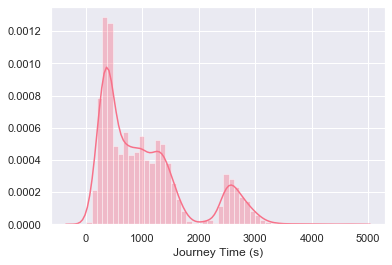

In [993]:
sns.distplot(df['Journey Time (s)'])

In [1443]:
# Get rid of outliers from dataset
def detect_outlier_z_score(travel_times):
    outlier_indexes = []
    
    threshold = 3
    mean = np.mean(travel_times)
    std = np.std(travel_times)
    
    for i, t in enumerate(travel_times):
        z_score= (t - mean) / std
        
        if np.abs(z_score) > threshold:
            outlier_indexes.append(i)
    
    return outlier_indexes

outlier_indexes = detect_outlier_z_score(df['Journey Time (s)'])
print("Outlier indexes: ", outlier_indexes)
df = df.drop(outlier_indexes)

Outlier indexes:  [2724, 2759, 2772, 2830, 2881, 2917, 2967, 3040, 3043, 3045, 3048, 7251, 7275, 7403, 7582, 7727, 9171, 9183]


In [1444]:
df

,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Gap,Arrival at Stop A,Arrival at Stop B
0,00:06:54,414.0,weekday,3,False,5,2020-04-16 03:11:10,2020-04-16 03:18:04
1,00:04:36,276.0,weekday,5,False,5,2020-04-16 05:04:07,2020-04-16 05:08:43
2,00:04:33,273.0,weekday,5,False,5,2020-04-16 05:16:17,2020-04-16 05:20:50
3,00:05:00,300.0,weekday,5,False,5,2020-04-16 05:22:17,2020-04-16 05:27:17
4,00:05:00,300.0,weekday,5,False,5,2020-04-16 05:29:17,2020-04-16 05:34:17
...,...,...,...,...,...,...,...,...
9185,00:40:11,2411.0,weekday,15,False,35,2020-04-16 14:43:00,2020-04-16 15:23:11
9186,00:46:26,2786.0,weekend,11,False,35,2020-04-19 11:03:00,2020-04-19 11:49:26
9187,00:48:10,2890.0,weekend,16,False,35,2020-04-19 15:23:00,2020-04-19 16:11:10
9188,00:41:01,2461.0,weekend,15,False,35,2020-05-09 15:02:10,2020-05-09 15:43:11


In [1445]:
df_new

,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Gap,Arrival at Stop A,Arrival at Stop B
0,00:04:51,291.0,weekend,5,False,5,2020-05-17 05:53:16,2020-05-17 05:58:07
1,00:04:53,293.0,weekend,6,False,5,2020-05-17 06:16:06,2020-05-17 06:20:59
2,00:05:26,326.0,weekend,6,False,5,2020-05-17 06:25:51,2020-05-17 06:31:17
3,00:03:49,229.0,weekend,6,False,5,2020-05-17 06:34:12,2020-05-17 06:38:01
4,00:03:51,231.0,weekend,6,False,5,2020-05-17 06:41:00,2020-05-17 06:44:51
...,...,...,...,...,...,...,...,...
4644,00:44:27,2667.0,weekday,8,True,35,2020-06-09 08:11:39,2020-06-09 08:56:06
4645,00:45:36,2736.0,weekday,9,True,35,2020-06-09 08:21:39,2020-06-09 09:07:15
4646,00:41:36,2496.0,weekday,9,True,35,2020-06-09 08:31:37,2020-06-09 09:13:13
4647,00:44:58,2698.0,weekday,9,True,35,2020-06-09 08:51:37,2020-06-09 09:36:35


In [1446]:
new = df.append(df_new, ignore_index=True)
print(new.shape)
new

(13821, 8)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Gap,Arrival at Stop A,Arrival at Stop B
0,00:06:54,414.0,weekday,3,False,5,2020-04-16 03:11:10,2020-04-16 03:18:04
1,00:04:36,276.0,weekday,5,False,5,2020-04-16 05:04:07,2020-04-16 05:08:43
2,00:04:33,273.0,weekday,5,False,5,2020-04-16 05:16:17,2020-04-16 05:20:50
3,00:05:00,300.0,weekday,5,False,5,2020-04-16 05:22:17,2020-04-16 05:27:17
4,00:05:00,300.0,weekday,5,False,5,2020-04-16 05:29:17,2020-04-16 05:34:17
...,...,...,...,...,...,...,...,...
13816,00:44:27,2667.0,weekday,8,True,35,2020-06-09 08:11:39,2020-06-09 08:56:06
13817,00:45:36,2736.0,weekday,9,True,35,2020-06-09 08:21:39,2020-06-09 09:07:15
13818,00:41:36,2496.0,weekday,9,True,35,2020-06-09 08:31:37,2020-06-09 09:13:13
13819,00:44:58,2698.0,weekday,9,True,35,2020-06-09 08:51:37,2020-06-09 09:36:35


In [1450]:
baby_dfs_new = [encode_df(baby) for baby in baby_dfs_new]
baby_dfs_new[0]

,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Gap,Arrival at Stop A,Arrival at Stop B,Day of Week Encoded,Pre Lockdown Encoded
0,00:04:51,291.0,weekend,5,False,5,2020-05-17 05:53:16,2020-05-17 05:58:07,1,0
1,00:04:53,293.0,weekend,6,False,5,2020-05-17 06:16:06,2020-05-17 06:20:59,1,0
2,00:05:26,326.0,weekend,6,False,5,2020-05-17 06:25:51,2020-05-17 06:31:17,1,0
3,00:03:49,229.0,weekend,6,False,5,2020-05-17 06:34:12,2020-05-17 06:38:01,1,0
4,00:03:51,231.0,weekend,6,False,5,2020-05-17 06:41:00,2020-05-17 06:44:51,1,0
...,...,...,...,...,...,...,...,...,...,...
1187,00:05:54,354.0,weekday,8,True,5,2020-06-09 08:31:37,2020-06-09 08:37:31,0,1
1188,00:06:33,393.0,weekday,8,True,5,2020-06-09 08:51:37,2020-06-09 08:58:10,0,1
1189,00:06:06,366.0,weekday,9,True,5,2020-06-09 09:01:50,2020-06-09 09:07:56,0,1
1190,00:05:59,359.0,weekday,9,True,5,2020-06-09 09:21:09,2020-06-09 09:27:08,0,1


In [1447]:
dow_encoder = preprocessing.LabelEncoder()
ld_encoder = preprocessing.LabelEncoder()
dow_encoder.fit(df['Day of Week'])
ld_encoder.fit(df['Pre Lockdown'])

def encode_df(df):
    encoded = dow_encoder.transform(df['Day of Week'])
    df['Day of Week Encoded'] = encoded
    encoded = ld_encoder.transform(df['Pre Lockdown'])
    df['Pre Lockdown Encoded'] = encoded
    return df

df = encode_df(df)
new = encode_df(new)
baby_dfs = [encode_df(baby) for baby in baby_dfs]

days_of_week_label = list(dow_encoder.inverse_transform([0,1]))
print(list(zip([0,1], days_of_week_label)))
pre_lockdown_label = list(ld_encoder.inverse_transform([0, 1]))
print(list(zip([0, 1], pre_lockdown_label)))

unflattened = {
    "Okehampton Road": baby_dfs[0],
    "Harrow Road / Kilburn Lane": baby_dfs[1],
    "Chesterton Road": baby_dfs[2],
    "Notting Hill Gate Station": baby_dfs[3],
    "Palace Gate": baby_dfs[4],
    "Knightsbridge Station  / Harrods": baby_dfs[5],
    "Victoria Bus Station": baby_dfs[6],
    "Green Park Station": baby_dfs[7],
    "Marble Arch / Edgware Road": baby_dfs[8],
    "Orchardson Street": baby_dfs[9],
    "Elgin Avenue": baby_dfs[10],
    "Fernhead Road": baby_dfs[11],
    "Wrentham Avenue": baby_dfs[12],
    "Clare Road": baby_dfs[13],
    "St Edmund's School": baby_dfs[14],
    "Byng Street": baby_dfs[15],
    "Canary Wharf Station": baby_dfs[16],
    "East India Dock Road": baby_dfs[17],
    "Mile End Station": baby_dfs[18],
    "Old Ford Road": baby_dfs[19],
    "Holcroft Road": baby_dfs[20]
}

print(df.shape)
print(new.shape)
new.head()

[(0, 'weekday'), (1, 'weekend')]
[(0, False), (1, True)]
(9172, 10)
(13821, 10)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Gap,Arrival at Stop A,Arrival at Stop B,Day of Week Encoded,Pre Lockdown Encoded
0,00:06:54,414.0,weekday,3,False,5,2020-04-16 03:11:10,2020-04-16 03:18:04,0,0
1,00:04:36,276.0,weekday,5,False,5,2020-04-16 05:04:07,2020-04-16 05:08:43,0,0
2,00:04:33,273.0,weekday,5,False,5,2020-04-16 05:16:17,2020-04-16 05:20:50,0,0
3,00:05:00,300.0,weekday,5,False,5,2020-04-16 05:22:17,2020-04-16 05:27:17,0,0
4,00:05:00,300.0,weekday,5,False,5,2020-04-16 05:29:17,2020-04-16 05:34:17,0,0


In [1452]:
oke_temp = unflattened.get("Okehampton Road")
oke_temp = oke_temp.append(baby_dfs_new[0])
oke_temp

,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Gap,Arrival at Stop A,Arrival at Stop B,Day of Week Encoded,Pre Lockdown Encoded
0,00:06:54,414.0,weekday,3,False,5,2020-04-16 03:11:10,2020-04-16 03:18:04,0,0
1,00:06:54,414.0,weekday,3,False,5,2020-04-16 03:11:10,2020-04-16 03:18:04,0,0
2,00:04:36,276.0,weekday,5,False,5,2020-04-16 05:04:07,2020-04-16 05:08:43,0,0
3,00:04:36,276.0,weekday,5,False,5,2020-04-16 05:04:07,2020-04-16 05:08:43,0,0
4,00:04:33,273.0,weekday,5,False,5,2020-04-16 05:16:17,2020-04-16 05:20:50,0,0
...,...,...,...,...,...,...,...,...,...,...
1187,00:05:54,354.0,weekday,8,True,5,2020-06-09 08:31:37,2020-06-09 08:37:31,0,1
1188,00:06:33,393.0,weekday,8,True,5,2020-06-09 08:51:37,2020-06-09 08:58:10,0,1
1189,00:06:06,366.0,weekday,9,True,5,2020-06-09 09:01:50,2020-06-09 09:07:56,0,1
1190,00:05:59,359.0,weekday,9,True,5,2020-06-09 09:21:09,2020-06-09 09:27:08,0,1


In [1260]:
df = new
df.describe()

,Journey Time,Journey Time (s),Time of Day,Gap,Day of Week Encoded,Pre Lockdown Encoded
count,13839,13839.000000,13839.000000,13839.000000,4649.000000,4649.000000
mean,0 days 00:18:01.945949,1081.945950,11.895802,14.592456,0.323295,0.514089
std,0 days 00:13:31.440053,811.440054,4.750562,9.494567,0.467785,0.499855
min,0 days 00:00:05,5.000000,0.000000,5.000000,0.000000,0.000000
25%,0 days 00:07:05,425.000000,8.000000,5.000000,0.000000,0.000000
50%,0 days 00:14:00,840.000000,12.000000,10.000000,0.000000,1.000000
75%,0 days 00:23:22,1402.000000,15.000000,20.000000,1.000000,1.000000
max,0 days 01:27:23,5243.000000,23.000000,35.000000,1.000000,1.000000


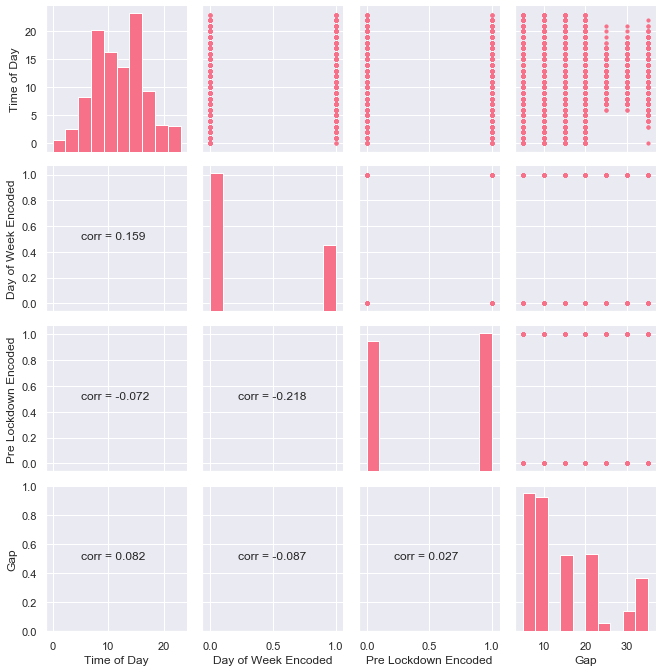

In [1261]:
from scipy.stats import pearsonr

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("corr = {:.3f}".format(r),
                xy=(.25, .5), xycoords=ax.transAxes)
    
pp = sns.PairGrid(df[['Time of Day', 'Day of Week Encoded', 'Pre Lockdown Encoded', 'Gap']], height = 2.3, diag_sharey=False)
pp.map_upper(plt.scatter, s=10)
pp.map_diag(plt.hist)
pp.map_lower(corrfunc)

#### Feature correlation

The above pairplot indicates that the features are not related to each other, i.e. they are independent of each other. This means that they can be used together in multivariate regression. This is supported by the Pearson Correlation Coefficients calculated for the three variables. The Pearson’s correlation coefficient is calculated as the covariance of the two variables divided by the product of the standard deviation of each data sample. It is the normalization of the covariance between the two variables to give an interpretable score. The coefficient returns a value between -1 and 1 that represents the limits of correlation from a full negative correlation to a full positive correlation. A value of 0 means no correlation. The value must be interpreted, where often a value below -0.5 or above 0.5 indicates a notable correlation, and values between those values suggests a less notable correlation.

#### Feature information

There is a lot more data that was collected post lockdown compared to pre lockdown (as can be seen by the bottom right graph that has a taller 0 = False bar).
There is data for post lockdown for weekdays and weekends, but for pre lockdown there is only weekday data.
For post lockdown data there is data for all times of day that the bus runs, but for pre lockdown there is only data for between 1000 to approximately 1800.

From the middle graph, it can be seen that there is a lot more data collected on weekdays compared to weekends.
It can also be seen from the top middle graph that on weekends, there are gaps during the day where data has not been collected. For example, there is no data after approximately 1800.

From the top left graph, it can be seen that the data trend is 2 humps (perhaps morning peak and evening peak).

## Linear Regression

Regression models are generally outperformed by other types of models, but they reveal which independent variable is less/more important for predicting travel times. However, I won't have time to develop a neural network model (probably), so I'll just have to try and make the regression models as good as the historical models if possible.

In order for the regression models to take into account recent data so that it is reactionary, the model is going to have to take in more limited data than it is currently. So it will have to do similar to the historical data e.g. the regression model will train only on the last 15 buses, or buses from the last 2 hours -> so will have to limit the data set depending on the request time. And then it can test on the request time.

Based on the historical models, the best ones are 1) looking back 15 buses 2) looking back 10 buses 3) looking back 5 buses.

So, because this is a regression model, it is possible that looking back 15 buses will not be as good as looking back x hours because there is fewer buses for the model to learn from and therefore it could underfit.

#### Measures of success:

- **r2 score**, also known as coefficient of determination. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
- **Root Mean Square Error** (rmse). Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. The smaller the better
- **Mean Absolute Percentage Error** (MAPE): Worst is 100, lower values are better. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error

When standardized observations and forecasts are used as RMSE inputs, there is a direct relationship with the correlation coefficient. For example, if the correlation coefficient is 1, the RMSE will be 0, because all of the points lie on the regression line (and therefore there are no errors).

In [1262]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def poly_regression_gap(degree, x_train, y_train, x_test, y_test):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(x_train)
    
    temp = pd.DataFrame([y_test], columns = ['Journey Time (s)'])
    y_test = temp['Journey Time (s)'][:, np.newaxis]

    x_train = poly.transform(x_train)
    x_test = poly.transform(x_test)

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)

    # Apply the model to the given past 10 journeys to predict the new ‘Journey Time’
    y_pred = linreg.predict(x_test)
    
    return y_pred

In [1263]:
def poly_regression_scale(degree, x_train, y_train, x_test, y_test):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(x_train)
    
    temp = pd.DataFrame([y_test], columns = ['Journey Time (s)'])
    y_test = temp['Journey Time (s)'][:, np.newaxis]

    x_train = poly.transform(x_train)
    x_test = poly.transform(x_test)
    
    # Scale the data
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(x_train)
    x_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_scaled, y_train)

    # Apply the model to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test_scaled)
    
    return y_pred

In [1435]:
def get_actual_times(most_recent_left_index, journeys):
    """
    Returns the arrival time and journey time (seconds) of the first bus that arrives 
    at arr_stop immediately after req_time.
    Want the one right after most recent left.
    """
    
    rev = journeys.sort_values(by='Arrival at Stop B', ascending=False, ignore_index=True)
    actual_jrny = rev.loc[[most_recent_left_index - 1] ,['Journey Time (s)']].values[0][0]
    actual = rev.loc[[most_recent_left_index - 1] ,:]
        
    return actual, actual_jrny

In [1436]:
def get_times_past_x_buses(journeys, req_time, buses_back):
    
    """
    most_recent_left
        - is the last vehicle to leave stop a and arrive at stop b before req_time.
    last_x_buses
        - list of the last buses_back number of buses to use for the regression model.
    time_to_request
        - list of the length of time a bus arrived at stop B before the request time.
        e.g. if the request time is 05.25.00 and the bus arrived at stop B at 05.18.00
        then the time_to_reqest is 00:07:00
    """

    indices = []
    last_x_buses = []
    time_to_request = []
    req_time = convert_time_to_datetime(req_time)
    count = 0
    
    # reverse direction of arrivals at stop b from latest first to earliest last
    rev = journeys.sort_values(by='Arrival at Stop B', ascending=False, ignore_index=True)

    for i, journey in rev.iterrows():
        arr_dt = convert_time_to_datetime(journey['Arrival at Stop B'])
        
        if arr_dt < req_time:
            # first one we encounter is the most recently arrived.
            last_x_buses.append(journey)
            diff = (req_time - arr_dt).total_seconds()
            time_to_request.append(diff)
            count = count + 1
            indices.append(i)
            
        if count == buses_back:
            break
    
    most_recent_left = -1
    if len(indices) > 0:
        most_recent_left = indices[0]
    
    return most_recent_left, last_x_buses, time_to_request

In [1266]:
def calc_weighted_avg(last_journeys):
#     weights = {"2": 0.45, "5": 0.3, "10": 0.2, "15": 0.05}
    weights = {"2": 0.55, "5": 0.35, "10": 0.1}
    pred = 0
    sum_weights = 0
    
    for index, item in enumerate(last_journeys):
        weight = 0
        if (index < 2):
            weight = weights["2"]
        elif (index < 5) & (index >= 2):
            weight = weights["5"]
        elif (index < 10) & (index >= 5):
            weight = weights["10"]
        elif (index < 15) & (index >= 10):
            weight = weights["15"]

        journey_time = item['Journey Time (s)']
        pred += weight * journey_time
        sum_weights += weight
    
    if sum_weights == 0:
        return pred
    
    pred = pred / sum_weights
    
    return pred

In [1267]:
def append_last_journeys(df, last_journeys, times_to_req):
    # Bus 1 is the most recent bus, Bus 15 is the furthest away bus
    
    for i in range(0, len(last_journeys)):
        col_1 = 'Bus ' + str(i)
        col_2 = 'Bus ' + str(i) + ' time to req'
        df[col_1] = last_journeys[i]['Journey Time (s)']
        df[col_2] = times_to_req[i]
        
    return df

In [1268]:
def append_last_journeys(df, last_journeys, times_to_req):
    # Bus 0 is the most recent bus, Bus 14 is the furthest away bus
    
    for i in range(0, len(last_journeys)):
        col_1 = 'Bus ' + str(i)
        col_2 = 'Bus ' + str(i) + ' time to req'
        df[col_1] = last_journeys[i]['Journey Time (s)']
        df[col_2] = times_to_req[i]
        
    return df

## Two Part Model

In [1272]:
req_times = generate_request_times(30, "2020-04-20 01:00:00", "2020-05-06 23:59:59")
req_times = req_times + generate_request_times(30, "2020-05-25 02:00:00", "2020-06-08 23:59:59")

req_times

['2020-04-20 01:00:00',
 '2020-04-20 01:30:00',
 '2020-04-20 02:00:00',
 '2020-04-20 02:30:00',
 '2020-04-20 03:00:00',
 '2020-04-20 03:30:00',
 '2020-04-20 04:00:00',
 '2020-04-20 04:30:00',
 '2020-04-20 05:00:00',
 '2020-04-20 05:30:00',
 '2020-04-20 06:00:00',
 '2020-04-20 06:30:00',
 '2020-04-20 07:00:00',
 '2020-04-20 07:30:00',
 '2020-04-20 08:00:00',
 '2020-04-20 08:30:00',
 '2020-04-20 09:00:00',
 '2020-04-20 09:30:00',
 '2020-04-20 10:00:00',
 '2020-04-20 10:30:00',
 '2020-04-20 11:00:00',
 '2020-04-20 11:30:00',
 '2020-04-20 12:00:00',
 '2020-04-20 12:30:00',
 '2020-04-20 13:00:00',
 '2020-04-20 13:30:00',
 '2020-04-20 14:00:00',
 '2020-04-20 14:30:00',
 '2020-04-20 15:00:00',
 '2020-04-20 15:30:00',
 '2020-04-20 16:00:00',
 '2020-04-20 16:30:00',
 '2020-04-20 17:00:00',
 '2020-04-20 17:30:00',
 '2020-04-20 18:00:00',
 '2020-04-20 18:30:00',
 '2020-04-20 19:00:00',
 '2020-04-20 19:30:00',
 '2020-04-20 20:00:00',
 '2020-04-20 20:30:00',
 '2020-04-20 21:00:00',
 '2020-04-20 21:

In [1275]:
# Gathering desired formats for training

# a dictionary of journey times accessed by stop name, ordered by time of request
training = {}

# all data appended onto each other
recents = pd.DataFrame()

for i, b in enumerate(stop_bs):
    print("{} to {}".format(stop_as[i], b))
    start = time.time()
    journeys = unflattened.get(b)
    
    route_data = pd.DataFrame()
    for req_time in req_times:
        
        most_recent_left_index, last_x_buses, time_to_req = get_times_past_x_buses(journeys, req_time, 10)
        
        if most_recent_left_index <= 0:
            continue

        actual, _ = get_actual_times(most_recent_left_index, journeys)
        actual = actual.drop(columns = ["Journey Time", "Day of Week", "Pre Lockdown", "Arrival at Stop A", "Arrival at Stop B"])
        
        test_row = append_last_journeys(actual, last_x_buses, time_to_req)
        recents = recents.append(test_row)
        route_data = route_data.append(test_row)
    
    training[b] = route_data
        
    print("Time taken: {}".format(time.time() - start))

Willesden Bus Garage to Okehampton Road
Time taken: 361.968994140625
Willesden Bus Garage to Harrow Road / Kilburn Lane
Time taken: 353.6925160884857
Willesden Bus Garage to Chesterton Road
Time taken: 207.2004358768463
Willesden Bus Garage to Notting Hill Gate Station
Time taken: 228.19806694984436
Willesden Bus Garage to Palace Gate
Time taken: 78.64933514595032
Willesden Bus Garage to Knightsbridge Station  / Harrods
Time taken: 112.84135389328003
Willesden Bus Garage to Victoria Bus Station
Time taken: 198.71304965019226
Charing Cross Station to Green Park Station
Time taken: 114.68291306495667
Charing Cross Station to Marble Arch / Edgware Road
Time taken: 109.42844223976135
Charing Cross Station to Orchardson Street
Time taken: 85.16954493522644
Charing Cross Station to Elgin Avenue
Time taken: 85.7074339389801
Charing Cross Station to Fernhead Road
Time taken: 19.806130170822144
Charing Cross Station to Wrentham Avenue
Time taken: 50.67712211608887
Charing Cross Station to Clare

In [1276]:
training["Okehampton Road"]

,Journey Time (s),Time of Day,Gap,Day of Week Encoded,Pre Lockdown Encoded,Bus 0,Bus 0 time to req,Bus 1,Bus 1 time to req,Bus 2,...,Bus 5,Bus 5 time to req,Bus 6,Bus 6 time to req,Bus 7,Bus 7 time to req,Bus 8,Bus 8 time to req,Bus 9,Bus 9 time to req
2002,210.0,3,5,0,0,354.0,7005.0,354.0,7005.0,453.0,...,310.0,8590.0,324.0,9421.0,324.0,9421.0,328.0,10226.0,328.0,10226.0
2002,210.0,3,5,0,0,354.0,8805.0,354.0,8805.0,453.0,...,310.0,10390.0,324.0,11221.0,324.0,11221.0,328.0,12026.0,328.0,12026.0
2002,210.0,3,5,0,0,354.0,10605.0,354.0,10605.0,453.0,...,310.0,12190.0,324.0,13021.0,324.0,13021.0,328.0,13826.0,328.0,13826.0
2002,210.0,3,5,0,0,354.0,12405.0,354.0,12405.0,453.0,...,310.0,13990.0,324.0,14821.0,324.0,14821.0,328.0,15626.0,328.0,15626.0
2002,210.0,3,5,0,0,354.0,14205.0,354.0,14205.0,453.0,...,310.0,15790.0,324.0,16621.0,324.0,16621.0,328.0,17426.0,328.0,17426.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,310.0,1,5,0,1,330.0,1331.0,370.0,3453.0,364.0,...,394.0,11379.0,394.0,12099.0,394.0,12568.0,432.0,16640.0,481.0,17375.0
30,310.0,1,5,0,1,330.0,3131.0,370.0,5253.0,364.0,...,394.0,13179.0,394.0,13899.0,394.0,14368.0,432.0,18440.0,481.0,19175.0
30,310.0,1,5,0,1,330.0,4931.0,370.0,7053.0,364.0,...,394.0,14979.0,394.0,15699.0,394.0,16168.0,432.0,20240.0,481.0,20975.0
30,310.0,1,5,0,1,330.0,6731.0,370.0,8853.0,364.0,...,394.0,16779.0,394.0,17499.0,394.0,17968.0,432.0,22040.0,481.0,22775.0


In [1277]:
recents

,Journey Time (s),Time of Day,Gap,Day of Week Encoded,Pre Lockdown Encoded,Bus 0,Bus 0 time to req,Bus 1,Bus 1 time to req,Bus 2,...,Bus 5,Bus 5 time to req,Bus 6,Bus 6 time to req,Bus 7,Bus 7 time to req,Bus 8,Bus 8 time to req,Bus 9,Bus 9 time to req
2002,210.0,3,5,0.0,0.0,354.0,7005.0,354.0,7005.0,453.0,...,310.0,8590.0,324.0,9421.0,324.0,9421.0,328.0,10226.0,328.0,10226.0
2002,210.0,3,5,0.0,0.0,354.0,8805.0,354.0,8805.0,453.0,...,310.0,10390.0,324.0,11221.0,324.0,11221.0,328.0,12026.0,328.0,12026.0
2002,210.0,3,5,0.0,0.0,354.0,10605.0,354.0,10605.0,453.0,...,310.0,12190.0,324.0,13021.0,324.0,13021.0,328.0,13826.0,328.0,13826.0
2002,210.0,3,5,0.0,0.0,354.0,12405.0,354.0,12405.0,453.0,...,310.0,13990.0,324.0,14821.0,324.0,14821.0,328.0,15626.0,328.0,15626.0
2002,210.0,3,5,0.0,0.0,354.0,14205.0,354.0,14205.0,453.0,...,310.0,15790.0,324.0,16621.0,324.0,16621.0,328.0,17426.0,328.0,17426.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2461.0,15,35,1.0,0.0,2890.0,1489730.0,2786.0,1505434.0,2411.0,...,2518.0,4247042.0,2410.0,4247481.0,2543.0,4247567.0,2513.0,4248667.0,2407.0,4249193.0
1,2461.0,15,35,1.0,0.0,2890.0,1491530.0,2786.0,1507234.0,2411.0,...,2518.0,4248842.0,2410.0,4249281.0,2543.0,4249367.0,2513.0,4250467.0,2407.0,4250993.0
1,2461.0,15,35,1.0,0.0,2890.0,1493330.0,2786.0,1509034.0,2411.0,...,2518.0,4250642.0,2410.0,4251081.0,2543.0,4251167.0,2513.0,4252267.0,2407.0,4252793.0
1,2461.0,15,35,1.0,0.0,2890.0,1495130.0,2786.0,1510834.0,2411.0,...,2518.0,4252442.0,2410.0,4252881.0,2543.0,4252967.0,2513.0,4254067.0,2407.0,4254593.0


### Part 1: predict travel time based on global conditions

$$y_{pred1} = b_0 + b_1x_1 + b_2x_2 + b_3x_3 + ... + b_{26}x_{26}$$

where 

- $x_1$ is the gap size between the stops
- $x_2$ is a binary value {0, 1} representing the day of week where 0 is weekday and 1 is weekend
- $x_3 ... x_{26}$ is the 1 hot encoding of time of day where $x_3$ represents the 0th hour of the day i.e. between 00:00 and 00:59, up to $x_{26}$ representing the 23rd hour of the day i.e. between 23:00 - 23:59. i.e. $x_i$ represents the i-3th hour of the day, for i = [3,26]

In [1278]:
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = OneHotEncoder()
one_hot_enc.fit(df['Time of Day'].values.reshape(-1, 1))
transformed = one_hot_enc.transform(df['Time of Day'].values.reshape(-1, 1)).toarray()
one_hot_encoded = pd.DataFrame(transformed, columns=one_hot_enc.categories_[0])

print(transformed.shape)
print(one_hot_encoded.shape)

(13839, 24)
(13839, 24)


In [1302]:
sub_df = new.drop(columns = ["Journey Time", "Day of Week", "Time of Day", "Pre Lockdown", "Pre Lockdown Encoded", "Arrival at Stop A", "Arrival at Stop B"])
sub_df = sub_df.reset_index()
sub_df = sub_df.join(one_hot_encoded)
print(sub_df.shape)
sub_df.head()

(13821, 28)


,index,Journey Time (s),Gap,Day of Week Encoded,0,1,2,3,4,5,...,14,15,16,17,18,19,20,21,22,23
0,0,414.0,5,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,276.0,5,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,273.0,5,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,300.0,5,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,300.0,5,0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1303]:
x_training = sub_df.drop(columns = ['index', 'Journey Time (s)'])
y_training = sub_df['Journey Time (s)'][:, np.newaxis]

# scale the data
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(x_training)
x_scaled = scaler.transform(x_training)

# train model on all collected data for set pairs of stops as specified above
linreg1 = LinearRegression()
linreg1.fit(x_scaled, y_training)

part1_coeffs = linreg1.coef_
part1_intercept = linreg1.intercept_

print(part1_coeffs)
print(part1_intercept)

[[ 7.78320354e+02 -2.15578663e+01  5.73810236e+12  6.16413662e+12
   6.90322104e+12  9.84142661e+12  1.12486687e+13  1.41533295e+13
   1.78363604e+13  1.87106607e+13  1.92728119e+13  2.02578876e+13
   2.12199016e+13  2.17152238e+13  2.01181975e+13  1.96601961e+13
   2.00780471e+13  2.12757351e+13  2.06500324e+13  1.84661903e+13
   1.53716651e+13  1.15428232e+13  1.10275325e+13  9.32177162e+12
   1.05914818e+13  6.93639804e+12]]
[1078.31645828]


In [1304]:
# validate the model on data collected from 20/04/2020 01:00:00 - 06/05/2020 23:59:59
x_tests1 = recents[['Time of Day', 'Gap', 'Day of Week Encoded']]
y_tests1 = recents['Journey Time (s)'].values

transformed1 = one_hot_enc.transform(x_tests1['Time of Day'].values.reshape(-1, 1)).toarray()
one_hot_encoded = pd.DataFrame(transformed1, columns=one_hot_enc.categories_[0])
x_tests1 = x_tests1.reset_index()
x_tests1 = x_tests1.join(one_hot_encoded)
x_tests1 = x_tests1.drop(columns = ['Time of Day', 'index'])

y_tests1 = y_tests1[:, np.newaxis]
x_tests_scaled = scaler.transform(x_tests1)
y_preds1 = linreg1.predict(x_tests_scaled)

In [1348]:
# validate on Okehampton road
okehampton = training['Okehampton Road']
x_tests1_okehampton = okehampton[['Time of Day', 'Gap', 'Day of Week Encoded']]
y_tests1_okehampton = okehampton['Journey Time (s)'].values

transformed1_okehampton = one_hot_enc.transform(x_tests1_okehampton['Time of Day'].values.reshape(-1, 1)).toarray()
one_hot_encoded_okehampton = pd.DataFrame(transformed1_okehampton, columns=one_hot_enc.categories_[0])
x_tests1_okehampton = x_tests1_okehampton.reset_index()
x_tests1_okehampton = x_tests1_okehampton.join(one_hot_encoded_okehampton)
x_tests1_okehampton = x_tests1_okehampton.drop(columns = ['Time of Day', 'index'])

y_tests1_okehampton = y_tests1_okehampton[:, np.newaxis]
x_tests_scaled_okehampton = scaler.transform(x_tests1_okehampton)
y_preds1_okehampton = linreg1.predict(x_tests_scaled_okehampton)


In [1305]:
# overall RMSE and MAPE
actual_vals = [x[0] for x in y_tests1]
mse = mean_squared_error(actual_vals, y_preds1)
rmse = np.sqrt(mse)
r2 = r2_score(actual_vals, y_preds1)
mape = mean_absolute_error(actual_vals, y_preds1)

print(rmse, r2, mape)

343.0913554346135 0.8686472489954826 224.58276009517235


In [ ]:
mapes = []
rmses = []

for i, pair in enumerate(stop_bs):
    gap = training[pair]
    x_tests_gap = gap[['Time of Day', 'Gap', 'Day of Week Encoded']]
    y_tests_gap = gap['Journey Time (s)'].values

    transformed_gap = one_hot_enc.transform(x_tests_gap['Time of Day'].values.reshape(-1, 1)).toarray()
    one_hot_encoded = pd.DataFrame(transformed_gap, columns=one_hot_enc.categories_[0])
    x_tests_gap = x_tests_gap.reset_index()
    x_tests_gap = x_tests_gap.join(one_hot_encoded)
    x_tests_gap = x_tests_gap.drop(columns = ['Time of Day', 'index'])

    y_tests_gap = y_tests_gap[:, np.newaxis]
    x_tests_scaled = scaler.transform(x_tests_gap)
    y_preds_gap = linreg.predict(x_tests_scaled)

    y_actual_gap = [x[0] for x in y_tests_gap]
    
    mse = mean_squared_error(y_actual_gap, y_preds_gap)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual_gap, y_preds_gap)
    mape = mean_absolute_error(y_actual_gap, y_preds_gap)
    print(r2)
    
    mapes.append(mape)
    rmses.append(rmse)

In [ ]:
# Could calculate RMSE and MAPE for differing gap sizes.
gap5 = training["Notting Hill Gate Station"]
x_tests_gap5 = gap5[['Time of Day', 'Gap', 'Day of Week Encoded']]
y_tests_gap5 = gap5['Journey Time (s)'].values

transformed_gap5 = one_hot_enc.transform(x_tests_gap5['Time of Day'].values.reshape(-1, 1)).toarray()
one_hot_encoded = pd.DataFrame(transformed_gap5, columns=one_hot_enc.categories_[0])
x_tests_gap5 = x_tests_gap5.reset_index()
x_tests_gap5 = x_tests_gap5.join(one_hot_encoded)
x_tests_gap5 = x_tests_gap5.drop(columns = ['Time of Day', 'index'])

y_tests_gap5 = y_tests_gap5[:, np.newaxis]
x_tests_scaled = scaler.transform(x_tests_gap5)
y_preds_gap5 = linreg.predict(x_tests_scaled)

y_actual_gap5 = [x[0] for x in y_tests_gap5]

times = [convert_time_to_datetime(t) for t in req_times]
pred = [x/60 for x in y_preds_gap5]
acc = [x/60 for x in y_actual_gap5]

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(times, acc, label="Actual journey time")
ax.plot(times, pred, label="Predicted journey time")
ax.set_xlabel("Time of request")
ax.set_ylabel("Journey Time (minutes)")
# ax.set_ylim(0, 40)
ax.set_title("Journey time of a bus from {} to {} gap {}".format(stop_as[0], stop_bs[0], gaps[0]))
ax.legend()

plt.show()

### Part 2: predict travel time based on local conditions

For all of the 3 sub models, if the y axis is journey time (s) and x axis is time since request, then $y_{pred2}$ is the intercept with the y axis. We are using interpolation to get the predicted value.

#### 2.1 Weighted average

$$y_{pred2} = weighted\_average\_of\_last\_15\_journeys$$

where the weights are as follows: weights_15 = {"2": 0.45, "5": 0.3, "10": 0.2, "15": 0.05}

#### 2.2 Line of Best Fit

$$y_{pred2} = line\_of\_best\_fit\_through\_last\_15\_journeys$$

We don't want to do a curve or cubic or anything of larger degree than 1 to fit the last 15 journeys because at the extremeties, the values would be very large or very small. Thus, the intercept (which is the predicted journey time), would also be very large or very small and not close enough to the desired predicted value.

#### 2.3 Natural Cubic Spline

$$y_{pred2} = fit\_a\_cubic\_spline\_to\_the\_last\_15\_journeys$$

Cubic splines fit a cubic curve up to the extremes where they flatten out.


In [1308]:
part2_df = recents.drop(columns = ['Time of Day', 'Day of Week Encoded', 'Gap', 'Pre Lockdown Encoded'])
print(part2_df.shape)
part2_df.head()

(20504, 21)


,Journey Time (s),Bus 0,Bus 0 time to req,Bus 1,Bus 1 time to req,Bus 2,Bus 2 time to req,Bus 3,Bus 3 time to req,Bus 4,...,Bus 5,Bus 5 time to req,Bus 6,Bus 6 time to req,Bus 7,Bus 7 time to req,Bus 8,Bus 8 time to req,Bus 9,Bus 9 time to req
2002,210.0,354.0,7005.0,354.0,7005.0,453.0,7748.0,453.0,7748.0,310.0,...,310.0,8590.0,324.0,9421.0,324.0,9421.0,328.0,10226.0,328.0,10226.0
2002,210.0,354.0,8805.0,354.0,8805.0,453.0,9548.0,453.0,9548.0,310.0,...,310.0,10390.0,324.0,11221.0,324.0,11221.0,328.0,12026.0,328.0,12026.0
2002,210.0,354.0,10605.0,354.0,10605.0,453.0,11348.0,453.0,11348.0,310.0,...,310.0,12190.0,324.0,13021.0,324.0,13021.0,328.0,13826.0,328.0,13826.0
2002,210.0,354.0,12405.0,354.0,12405.0,453.0,13148.0,453.0,13148.0,310.0,...,310.0,13990.0,324.0,14821.0,324.0,14821.0,328.0,15626.0,328.0,15626.0
2002,210.0,354.0,14205.0,354.0,14205.0,453.0,14948.0,453.0,14948.0,310.0,...,310.0,15790.0,324.0,16621.0,324.0,16621.0,328.0,17426.0,328.0,17426.0


In [1351]:
okehampton_2 = okehampton.drop(columns = ['Time of Day', 'Day of Week Encoded', 'Gap', 'Pre Lockdown Encoded'])
print(okehampton_2.shape)
okehampton_2.head()

(1532, 21)


,Journey Time (s),Bus 0,Bus 0 time to req,Bus 1,Bus 1 time to req,Bus 2,Bus 2 time to req,Bus 3,Bus 3 time to req,Bus 4,...,Bus 5,Bus 5 time to req,Bus 6,Bus 6 time to req,Bus 7,Bus 7 time to req,Bus 8,Bus 8 time to req,Bus 9,Bus 9 time to req
2002,210.0,354.0,7005.0,354.0,7005.0,453.0,7748.0,453.0,7748.0,310.0,...,310.0,8590.0,324.0,9421.0,324.0,9421.0,328.0,10226.0,328.0,10226.0
2002,210.0,354.0,8805.0,354.0,8805.0,453.0,9548.0,453.0,9548.0,310.0,...,310.0,10390.0,324.0,11221.0,324.0,11221.0,328.0,12026.0,328.0,12026.0
2002,210.0,354.0,10605.0,354.0,10605.0,453.0,11348.0,453.0,11348.0,310.0,...,310.0,12190.0,324.0,13021.0,324.0,13021.0,328.0,13826.0,328.0,13826.0
2002,210.0,354.0,12405.0,354.0,12405.0,453.0,13148.0,453.0,13148.0,310.0,...,310.0,13990.0,324.0,14821.0,324.0,14821.0,328.0,15626.0,328.0,15626.0
2002,210.0,354.0,14205.0,354.0,14205.0,453.0,14948.0,453.0,14948.0,310.0,...,310.0,15790.0,324.0,16621.0,324.0,16621.0,328.0,17426.0,328.0,17426.0


In [1310]:
import math

#2.1 Weighted average

weights_10 = {"2": 0.55, "5": 0.35, "10": 0.1}
weights_15 = {"2": 0.45, "5": 0.3, "10": 0.2, "15": 0.05}

weights = weights_10
part2_df1 = pd.DataFrame()

for i, row in part2_df.iterrows():
    pred = 0
    sum_weights = 0
    
    for j in range(0, 10):
        weight = 0
        
        if (j < 2):
            weight = weights["2"]
        elif (j < 5) & (j >= 2):
            weight = weights["5"]
        elif (j < 10) & (j >= 5):
            weight = weights["10"]
        elif (j < 15) & (j >= 10):
            weight = weights["15"]
        
        col_name = "Bus " + str(j)
        journey_time = row[col_name]
        
        if math.isnan(journey_time):
            continue
        
        pred += weight * journey_time
        sum_weights += weight

    if sum_weights == 0:
        pred = 0
        # shouldn't get here though
        continue
    
    pred = pred / sum_weights
    row['Pred Journey Time (s)'] = pred
    part2_df1 = part2_df1.append(row)


print(part2_df1.shape)
part2_df1.head()

(20504, 22)


,Bus 0,Bus 0 time to req,Bus 1,Bus 1 time to req,Bus 2,Bus 2 time to req,Bus 3,Bus 3 time to req,Bus 4,Bus 4 time to req,...,Bus 6,Bus 6 time to req,Bus 7,Bus 7 time to req,Bus 8,Bus 8 time to req,Bus 9,Bus 9 time to req,Journey Time (s),Pred Journey Time (s)
2002,354.0,7005.0,354.0,7005.0,453.0,7748.0,453.0,7748.0,310.0,8590.0,...,324.0,9421.0,324.0,9421.0,328.0,10226.0,328.0,10226.0,210.0,368.45283
2002,354.0,8805.0,354.0,8805.0,453.0,9548.0,453.0,9548.0,310.0,10390.0,...,324.0,11221.0,324.0,11221.0,328.0,12026.0,328.0,12026.0,210.0,368.45283
2002,354.0,10605.0,354.0,10605.0,453.0,11348.0,453.0,11348.0,310.0,12190.0,...,324.0,13021.0,324.0,13021.0,328.0,13826.0,328.0,13826.0,210.0,368.45283
2002,354.0,12405.0,354.0,12405.0,453.0,13148.0,453.0,13148.0,310.0,13990.0,...,324.0,14821.0,324.0,14821.0,328.0,15626.0,328.0,15626.0,210.0,368.45283
2002,354.0,14205.0,354.0,14205.0,453.0,14948.0,453.0,14948.0,310.0,15790.0,...,324.0,16621.0,324.0,16621.0,328.0,17426.0,328.0,17426.0,210.0,368.45283


In [1352]:
import math

#2.1 Weighted average for Okehampton

weights_10 = {"2": 0.55, "5": 0.35, "10": 0.1}
weights_15 = {"2": 0.45, "5": 0.3, "10": 0.2, "15": 0.05}

weights = weights_10
part2_okehampton = pd.DataFrame()

for i, row in okehampton_2.iterrows():
    pred = 0
    sum_weights = 0
    
    for j in range(0, 10):
        weight = 0
        
        if (j < 2):
            weight = weights["2"]
        elif (j < 5) & (j >= 2):
            weight = weights["5"]
        elif (j < 10) & (j >= 5):
            weight = weights["10"]
        elif (j < 15) & (j >= 10):
            weight = weights["15"]
        
        col_name = "Bus " + str(j)
        journey_time = row[col_name]
        
        if math.isnan(journey_time):
            continue
        
        pred += weight * journey_time
        sum_weights += weight

    if sum_weights == 0:
        pred = 0
        # shouldn't get here though
        continue
    
    pred = pred / sum_weights
    row['Pred Journey Time (s)'] = pred
    part2_okehampton = part2_okehampton.append(row)


print(part2_okehampton.shape)
part2_okehampton.head()

(1532, 22)


,Bus 0,Bus 0 time to req,Bus 1,Bus 1 time to req,Bus 2,Bus 2 time to req,Bus 3,Bus 3 time to req,Bus 4,Bus 4 time to req,...,Bus 6,Bus 6 time to req,Bus 7,Bus 7 time to req,Bus 8,Bus 8 time to req,Bus 9,Bus 9 time to req,Journey Time (s),Pred Journey Time (s)
2002,354.0,7005.0,354.0,7005.0,453.0,7748.0,453.0,7748.0,310.0,8590.0,...,324.0,9421.0,324.0,9421.0,328.0,10226.0,328.0,10226.0,210.0,368.45283
2002,354.0,8805.0,354.0,8805.0,453.0,9548.0,453.0,9548.0,310.0,10390.0,...,324.0,11221.0,324.0,11221.0,328.0,12026.0,328.0,12026.0,210.0,368.45283
2002,354.0,10605.0,354.0,10605.0,453.0,11348.0,453.0,11348.0,310.0,12190.0,...,324.0,13021.0,324.0,13021.0,328.0,13826.0,328.0,13826.0,210.0,368.45283
2002,354.0,12405.0,354.0,12405.0,453.0,13148.0,453.0,13148.0,310.0,13990.0,...,324.0,14821.0,324.0,14821.0,328.0,15626.0,328.0,15626.0,210.0,368.45283
2002,354.0,14205.0,354.0,14205.0,453.0,14948.0,453.0,14948.0,310.0,15790.0,...,324.0,16621.0,324.0,16621.0,328.0,17426.0,328.0,17426.0,210.0,368.45283


In [ ]:
# 2.2 line of best fit

def poly_regression(degree, x_train, y_train):
    # Line of best fit, so degree = 1, but have code this way so it can try higher degrees if want.
    x_train = np.array(x_train).reshape(-1, 1)
    y_train = np.array(y_train).reshape(-1, 1)
    
    poly = PolynomialFeatures(degree = degree)
    poly.fit(x_train)
    
    x_train = poly.transform(x_train)

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)
    
    # The intercept is the predicted journey time
    return linreg.intercept_

preds_line = []
example_route2 = []

start = time.time()
for index, row in part2_df.iterrows():

    last = row.drop(columns=['Journey Time (s)'])

    part2_x = []
    part2_y = []

    for i in range(0, 10):
        col1 = "Bus " + str(i)
        col2 = "Bus " + str(i) + " time to req"
        jrny = last[col1]
        time_to_req = last[col2]
        
        if math.isnan(jrny) or math.isnan(time_to_req):
            continue
            
        part2_y.append(jrny)
        part2_x.append(time_to_req)
    
    prediction = poly_regression(1, part2_x, part2_y)
    
    if index == 792:
        example_route2.append(prediction)
        
    preds_line.append(prediction)

print("Time taken {}".format(time.time() - start))

In [1391]:
# 2.2 line of best fit for Okehampton

part2_okehampton_line = []

start = time.time()
for index, row in okehampton_2.iterrows():

    last = row.drop(columns=['Journey Time (s)'])

    part2_x = []
    part2_y = []

    for i in range(0, 10):
        col1 = "Bus " + str(i)
        col2 = "Bus " + str(i) + " time to req"
        jrny = last[col1]
        time_to_req = last[col2]
        
        if math.isnan(jrny) or math.isnan(time_to_req):
            continue
            
        part2_y.append(jrny)
        part2_x.append(time_to_req)
    
    prediction = poly_regression(1, part2_x, part2_y)
        
    part2_okehampton_line.append(prediction)

print("Time taken {}".format(time.time() - start))

Time taken 3.503031015396118


In [1324]:
from scipy.interpolate import CubicSpline

# 2.3 Natural Cubic Spline

preds_cs = []
preds_cs_nat = []
preds_cs_clamped = []

start = time.time()
for index, row in part2_df.iterrows():
    
    last = row.drop(columns=['Journey Time (s)'])

    part2_x = []
    part2_y = []

    for i in range(0, 10):
        col1 = "Bus " + str(i)
        col2 = "Bus " + str(i) + " time to req"
        jrny = last[col1]
        time_to_req = last[col2]

        if math.isnan(jrny) or math.isnan(time_to_req):
            continue

        if i > 0:
            # double check that the x values are strictly increasing
            last_time = part2_x[-1]
                
            if (last_time >= time_to_req):
                continue
           
        part2_y.append(jrny)
        part2_x.append(time_to_req)
 
    if len(part2_x) < 2:
        # Can't perform cubic spline interpolation as too few data, so do line of best fit instead
        prediction = poly_regression(1, part2_x, part2_y)
        preds_cs.append(prediction)
        preds_cs_nat.append(prediction)
        preds_cs_clamped.append(prediction)
    else:
        cubic_spline = CubicSpline(part2_x, part2_y)
        cubic_spline_nat = CubicSpline(part2_x, part2_y, bc_type='natural')
        cubic_spline_clamped = CubicSpline(part2_x, part2_y, bc_type='clamped')

        pred_cs = cubic_spline([0])
        pred_cs_nat = cubic_spline_nat([0])
        pred_cs_clamped = cubic_spline_clamped([0])

        preds_cs.append(pred_cs)
        preds_cs_nat.append(pred_cs_nat)
        preds_cs_clamped.append(pred_cs_clamped)
    
print("Time taken {}".format(time.time() - start))

Time taken 41.340364933013916


[168.76708916] [334.98990392] [542.13662903]


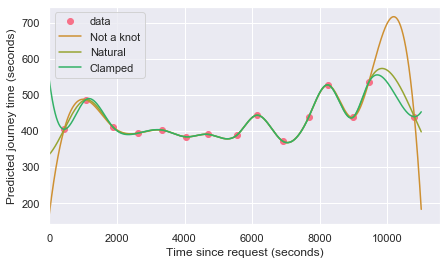

In [1237]:
temp = part2_df.iloc[792]
last_15 = temp.drop(columns=['Journey Time (s)'])

part2_x2 = []
part2_y2 = []

for i in range(0, 15):
    col1 = "Bus " + str(i)
    col2 = "Bus " + str(i) + " time to req"
    jrny = last_15[col1]
    time_to_req = last_15[col2]

    if math.isnan(jrny) or math.isnan(time_to_req):
        continue

    part2_y2.append(jrny)
    part2_x2.append(time_to_req)

cs = CubicSpline(part2_x2, part2_y2)
cs_nat = CubicSpline(part2_x2, part2_y2, bc_type='natural')
cs_clamped = CubicSpline(part2_x2, part2_y2, bc_type='clamped')

print(cs([0]), cs_nat([0]), cs_clamped([0]))

xs = np.arange(0, 11000, 0.1)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(part2_x2, part2_y2, 'o', label='data')
ax.plot(xs, cs(xs), label = "Not a knot")
ax.plot(xs, cs_nat(xs), label = "Natural")
ax.plot(xs, cs_clamped(xs), label = "Clamped")
ax.legend(loc='upper left')
ax.set_xlim(0)
ax.set_xlabel("Time since request (seconds)")
ax.set_ylabel("Predicted journey time (seconds)")
plt.show()

#### Comparing the 3 sub models

In [1312]:
# validate the model on data collected from 20/04/2020 01:00:00 - 06/05/2020 23:59:59
"""
part2_df1 contains the predicted and actual journey times calculated based on the weighted
average of the past 15 journeys for data collected from 20/04/2020 - 06/05/2020. The stops
collected for are as above and are ordered from Okehampton Road (Route 52) to 
Holcroft Road (Route 277)

Requests were made every 30 minutes, so row 1 corresponds to a request made at 02:00 at
Okehampton Road

Graph showing the last 10 journeys for a particular bus requested at 20/04/2020 
792 row 9, 798 row 8
"""

past_x_journeys = []
past_x_time_to_req = []
example_route = part2_df1.iloc[792]

for i in range (0, 10):
    col1 = "Bus " + str(i)
    col2 = "Bus " + str(i) + " time to req"
    past_x_journeys.append(example_route[col1])
    past_x_time_to_req.append(example_route[col2])


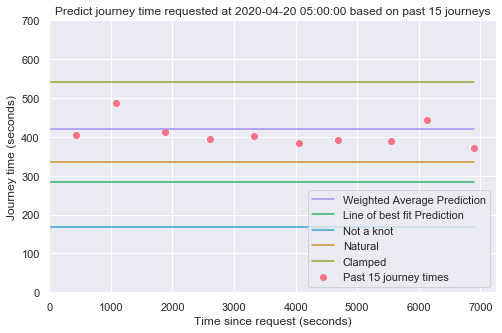

In [1325]:
weighted_avg_pred = [example_route['Pred Journey Time (s)'] for i in range(0, len(past_x_time_to_req) + 1)]
line_of_best_fit_pred = [example_route2[0] for i in range(0, len(past_x_time_to_req) + 1)]
not_a_knot_pred = [cs([0])[0] for i in range(0, len(past_x_time_to_req) + 1)]
natural_pred = [cs_nat([0])[0] for i in range(0, len(past_x_time_to_req) + 1)]
clamped_pred = [cs_clamped([0])[0] for i in range(0, len(past_x_time_to_req) + 1)]

x_times = np.insert(past_x_time_to_req, 0, 0)

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(past_x_time_to_req, past_x_journeys, label="Past 15 journey times")
ax.plot(x_times, weighted_avg_pred, label="Weighted Average Prediction", color=colours[6])
ax.plot(x_times, line_of_best_fit_pred, label="Line of best fit Prediction", color=colours[3])
ax.plot(x_times, not_a_knot_pred, label = "Not a knot", color=colours[5])
ax.plot(x_times, natural_pred, label = "Natural", color=colours[1])
ax.plot(x_times, clamped_pred, label = "Clamped", color=colours[2])
ax.set_xlabel("Time since request (seconds)")
ax.set_ylabel("Journey time (seconds)")
ax.set_xlim(0)
ax.set_ylim(0, 700)
ax.legend(loc='lower right')
ax.set_title("Predict journey time requested at {} based on past 15 journeys".format(times[8]))
plt.show()

### Combining 2 parts: predict travel time based on part 1 and part 2

**The hypothesis is**: the journey time of a bus depends on both recent data as well as global conditions (in this case, the time of day, the day of week, the distance between the stops etc.). Therefore, a regression model that attempts to predict a journey time for a bus between 2 stops requires both recent data to indicate current traffic conditions as well as global data.

$$y_{pred} = \alpha y_{pred1} + (1 - \alpha)y_{pred2}$$

where
- $y_{pred}$ is the overall journey time prediction that we are looking for
- $\alpha$ is some coefficient that we are looking to find such that it minimises the validation error. 

#### Combine part 1 with 2.1 weighted average

In [1326]:
# Combine part 1 with 2.1 weighted average

y_preds1 = [m[0] for m in y_preds1]
y_preds1 = np.array(y_preds1)
y_preds2_weighted_avg = part2_df1['Pred Journey Time (s)']
y_actual = part2_df1['Journey Time (s)']

print(type(y_actual.values))
print(type(y_preds1))
print(type(y_preds2_weighted_avg.values))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [1333]:
print(len(y_preds1))
print(len(y_preds2_weighted_avg))
print(len(preds_line))

20504
20504
20504


In [1374]:
alphas1 = np.linspace(0, 0.2, num=20)
y_pred_final = []
rmses_weighted_avg = []
mapes_weighted_avg = []

for alpha in alphas1:
    y_pred = alpha * (y_preds1) + (1 - alpha) * (y_preds2_weighted_avg)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual, y_pred)
    mape = mean_absolute_error(y_actual, y_pred)
    
    print(r2)
    y_pred_final.append(y_pred)
    rmses_weighted_avg.append(rmse)
    mapes_weighted_avg.append(mape)

0.9198910670848855
0.9199162854399516
0.919929490455304
0.9199306821309431
0.9199198604668687
0.9198970254630807
0.9198621771195794
0.9198153154363645
0.9197564404134362
0.9196855520507944
0.919602650348439
0.9195077353063703
0.919400806924588
0.9192818652030923
0.9191509101418831
0.9190079417409605
0.9188529600003243
0.9186859649199747
0.9185069564999115
0.918315934740135


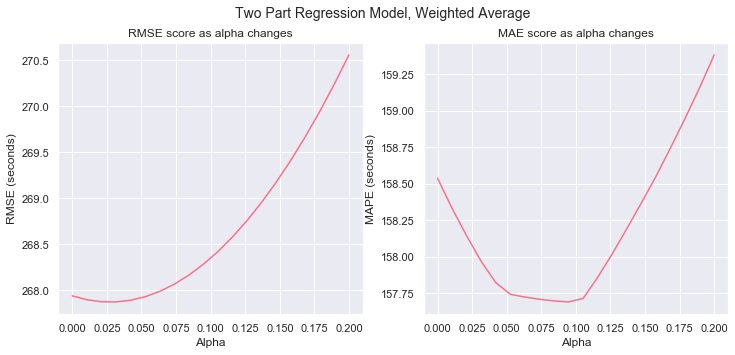

In [1375]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot(alphas1, rmses_weighted_avg)
ax[0].set_title("RMSE score as alpha changes")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("RMSE (seconds)")

ax[1].plot(alphas1, mapes_weighted_avg)
ax[1].set_title("MAE score as alpha changes")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("MAPE (seconds)")

fig.suptitle("Two Part Regression Model, Weighted Average", fontsize=14)
plt.show()

#### Combine part 1 with 2.2 line of best fit

In [1376]:
y_preds2_line = np.array([m[0] for m in preds_line])

alphas2 = np.linspace(0.8, 1, num=20)
y_pred_final_line = []
rmses_line = []
mapes_line = []

for alpha in alphas2:
    y_pred = alpha * (y_preds1) + (1 - alpha) * (y_preds2_line)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    r2_line = r2_score(y_actual, y_pred)
    mape = mean_absolute_error(y_actual, y_pred)
    
    y_pred_final_line.append(y_pred)
    rmses_line.append(rmse)
    mapes_line.append(mape)
    
    print(r2_line)

0.6444122460118136
0.6702647791289503
0.6945561243733269
0.717286281744944
0.7384552512438014
0.7580630328698986
0.7761096266232362
0.7925950325038141
0.8075192505116322
0.8208822806466902
0.8326841229089886
0.8429247772985271
0.851604243815306
0.8587225224593249
0.8642796132305841
0.8682755161290834
0.8707102311548229
0.8715837583078027
0.8708960975880226
0.8686472489954826


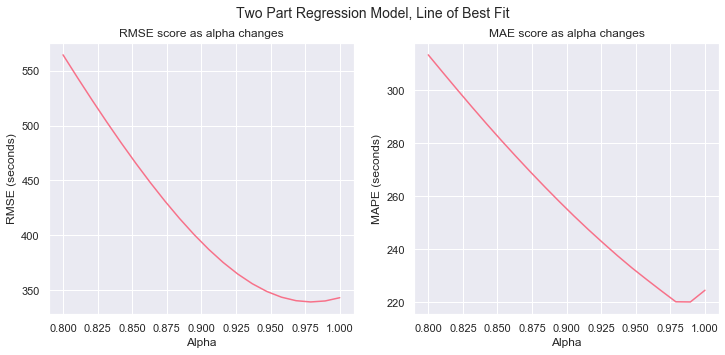

In [1377]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot(alphas2, rmses_line)
ax[0].set_title("RMSE score as alpha changes")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("RMSE (seconds)")

ax[1].plot(alphas2, mapes_line)
ax[1].set_title("MAE score as alpha changes")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("MAPE (seconds)")

fig.suptitle("Two Part Regression Model, Line of Best Fit", fontsize=14)
plt.show()

#### Combine part 1 with 2.3 cubic splines

In [1336]:
y_preds2_cs = np.array([m[0] for m in preds_cs])
y_preds2_cs_nat = np.array([m[0] for m in preds_cs_nat])
y_preds2_cs_clamped = np.array([m[0] for m in preds_cs_clamped])
y_preds2_cubicsplines = [y_preds2_cs, y_preds2_cs_nat, y_preds2_cs_clamped]

alphas = np.linspace(0.9, 1, num=20)
y_pred_final_cubicsplines = []
rmses_cubicsplines = []
mapes_cubicsplines = []


for i in range(0, 3):
    temp_ypreds = []
    temp_rmses = []
    temp_mapes = []
    temp_r2s = []
    
    for alpha in alphas:
        y_pred = alpha * (y_preds1) + (1 - alpha) * (y_preds2_cubicsplines[i])
        mse = mean_squared_error(y_actual, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_actual, y_pred)
        mape = mean_absolute_error(y_actual, y_pred)

        temp_ypreds.append(y_pred)
        temp_rmses.append(rmse)
        temp_mapes.append(mape)
        temp_r2s.append(r2)
    
    print(temp_r2s)
    
    y_pred_final_cubicsplines.append(temp_ypreds)
    rmses_cubicsplines.append(temp_rmses)
    mapes_cubicsplines.append(temp_mapes)

[-292123206636439.25, -262182600927546.47, -233860406340481.2, -207156622875243.6, -182071250531834.22, -158604289310251.78, -136755739210497.05, -116525600232569.95, -97913872376470.47, -80920555642198.58, -65545650029754.63, -51789155539137.96, -39651072170348.94, -29131399923387.52, -20230138798253.73, -12947288794947.56, -7282849913469.12, -3236822153818.1655, -809205515994.8369, 0.8686472489954826]
[-1695956445685032.8, -1522132654953506.2, -1357704744796330.5, -1202672715213504.5, -1057036566205033.2, -920796297770909.1, -793951909911136.0, -676503402625713.2, -568450775914641.6, -469794029777920.25, -380533164215551.75, -300668179227531.94, -230199074813862.66, -169125850974544.28, -117448507709576.58, -75167045018959.66, -42281462902694.01, -18791761360778.32, -4697940393213.359, 0.8686472489954826]
[-3.3332799723567428e+16, -2.9916418588891224e+16, -2.6684706704713732e+16, -2.3637664071034964e+16, -2.0775290687854972e+16, -1.8097586555173624e+16, -1.5604551672991e+16, -1.32961

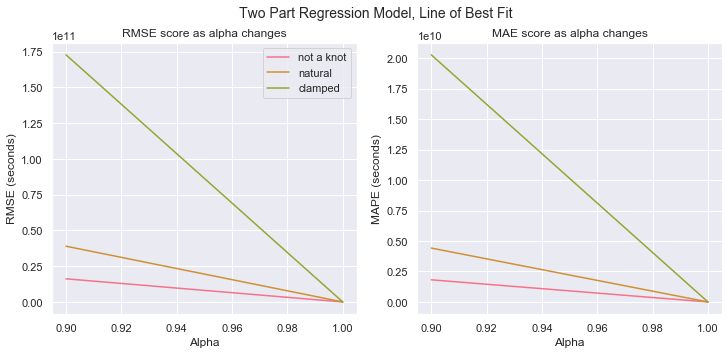

In [1337]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot(alphas, rmses_cubicsplines[0], label="not a knot")
ax[0].plot(alphas, rmses_cubicsplines[1], label="natural")
ax[0].plot(alphas, rmses_cubicsplines[2], label="clamped")
ax[0].set_title("RMSE score as alpha changes")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("RMSE (seconds)")
ax[0].legend()

ax[1].plot(alphas, mapes_cubicsplines[0], label="not a knot")
ax[1].plot(alphas, mapes_cubicsplines[1], label="natural")
ax[1].plot(alphas, mapes_cubicsplines[2], label="clamped")
ax[1].set_title("MAE score as alpha changes")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("MAPE (seconds)")

fig.suptitle("Two Part Regression Model, Line of Best Fit", fontsize=14)
plt.show()

# ok this makes sense because if the time of request is far from the origin, then the value at 0 will be an extreme

### Look at a gap of 5: Willesden Bus Garage to Okehampton Road


look at gap of 5 for direct comparison against historical model.

In [1369]:
y_preds1_okehampton = [m[0] for m in y_preds1_okehampton]
y_preds1_okehampton = np.array(y_preds1_okehampton)
y_preds2_okehampton = part2_okehampton['Pred Journey Time (s)']
y_actual_okehampton = part2_okehampton['Journey Time (s)']

In [1405]:
print(y_preds1_okehampton.shape)
print(y_preds2_okehampton.shape)
print(y_actual_okehampton.shape)

(1532,)
(1532,)
(1532,)


In [1387]:
alphas3 = np.linspace(0, 0.5, num=20)
y_pred_gap5 = []
rmses_gap5_wa = []
mapes_gap5_wa = []

for alpha in alphas3:
    y_pred = alpha * (y_preds1_okehampton) + (1 - alpha) * (y_preds2_okehampton)
    mse = mean_squared_error(y_actual_okehampton, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual_okehampton, y_pred)
    mape = mean_absolute_error(y_actual_okehampton, y_pred)
    
    y_pred_gap5.append(y_pred)
    rmses_gap5_wa.append(rmse)
    mapes_gap5_wa.append(mape)
    
    print(r2)

0.11324373036176938
0.1303477827663191
0.14513082383234388
0.15759285355984476
0.16773387194882072
0.17555387899927233
0.18105287471119946
0.18423085908460157
0.18508783211947932
0.1836237938158325
0.1798387441736614
0.1737326831929653
0.16530561087374485
0.1545575272159999
0.14148843221973018
0.12609832588493586
0.10838720821161729
0.08835507919977414
0.06600193884940653
0.041327787160513774


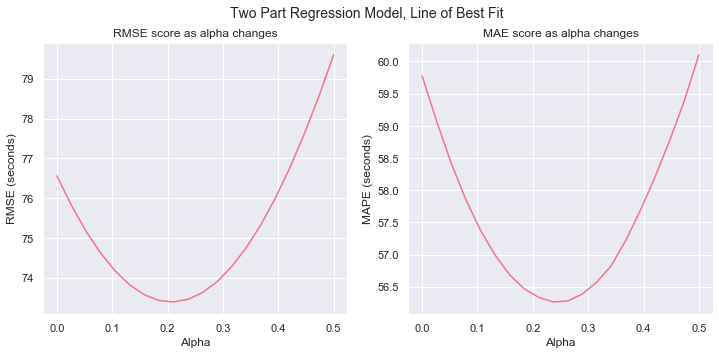

In [1390]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot(alphas3, rmses_gap5_wa)
ax[0].set_title("RMSE score as alpha changes")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("RMSE (seconds)")

ax[1].plot(alphas3, mapes_gap5_wa)
ax[1].set_title("MAE score as alpha changes")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("MAPE (seconds)")

fig.suptitle("Regression Model with Weighted Avg as Part 2 Sub-Model", fontsize=14)
plt.show()

In [1415]:
y_preds2_okehampton_line = [m[0] for m in part2_okehampton_line]
y_preds2_okehampton_line = np.array(y_preds2_okehampton_line)
print(y_preds2_okehampton_line.shape)
print(len(y_preds1_okehampton))

(1532,)
1532


In [1419]:
alphas4 = np.linspace(0.8, 1, num=20)
y_pred_gap5_line = []
rmses_gap5_line = []
mapes_gap5_line = []

for alpha in alphas4:
    y_pred = alpha * (y_preds1_okehampton) + (1 - alpha) * (y_preds2_okehampton_line)
    mse = mean_squared_error(y_actual_okehampton, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual_okehampton, y_pred)
    mape = mean_absolute_error(y_actual_okehampton, y_pred)
    
    y_pred_gap5_line.append(y_pred)
    rmses_gap5_line.append(rmse)
    mapes_gap5_line.append(mape)
    
    print(r2)

-2.0694190056620654
-1.9241690282880985
-1.7880348626901061
-1.661016508868086
-1.543113966822038
-1.4343272365519657
-1.3346563180578639
-1.244101211339736
-1.1626619163975818
-1.0903384332314014
-1.0271307618411925
-0.9730389022269579
-0.9280628543886957
-0.8922026183264069
-0.8654581940400914
-0.8478295815297487
-0.8393167807953794
-0.8399197918369832
-0.8496386146545596
-0.8684732492481098


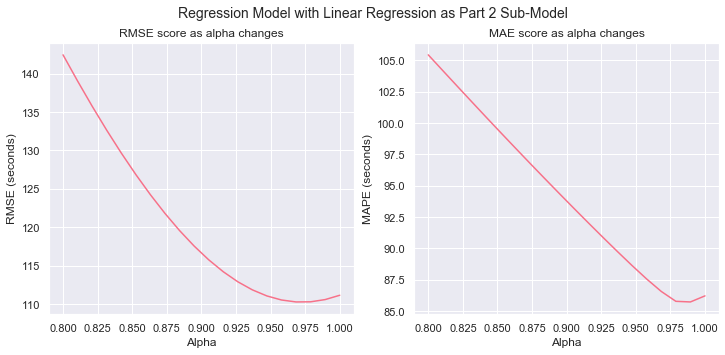

In [1420]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot(alphas4, rmses_gap5_line)
ax[0].set_title("RMSE score as alpha changes")
ax[0].set_xlabel("Alpha")
ax[0].set_ylabel("RMSE (seconds)")

ax[1].plot(alphas4, mapes_gap5_line)
ax[1].set_title("MAE score as alpha changes")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("MAPE (seconds)")

fig.suptitle("Regression Model with Linear Regression as Part 2 Sub-Model", fontsize=14)
plt.show()

In [1422]:
mape_weighted_avg = min(mapes_gap5_wa)
rmse_weighted_avg = min(rmses_gap5_wa)
index = mapes_gap5_wa.index(mape_weighted_avg)
alpha_weighted_avg_mape = alphas3[index]
index = rmses_gap5_wa.index(rmse_weighted_avg)
alpha_weighted_avg_rmse = alphas3[index]
print(mape_weighted_avg, alpha_weighted_avg_mape, rmse_weighted_avg, alpha_weighted_avg_rmse)

mape_line = min(mapes_gap5_line)
rmse_line = min(rmses_gap5_line)
index = mapes_gap5_line.index(mape_line)
alpha_line_mape = alphas4[index]
index = rmses_gap5_line.index(rmse_line)
alpha_line_rmse = alphas4[index]
print(mape_line, alpha_line_mape, rmse_line, alpha_line_rmse)

56.263312593858736 0.23684210526315788 73.38946615390863 0.21052631578947367
85.72679090484823 0.9894736842105263 110.25710722587137 0.968421052631579


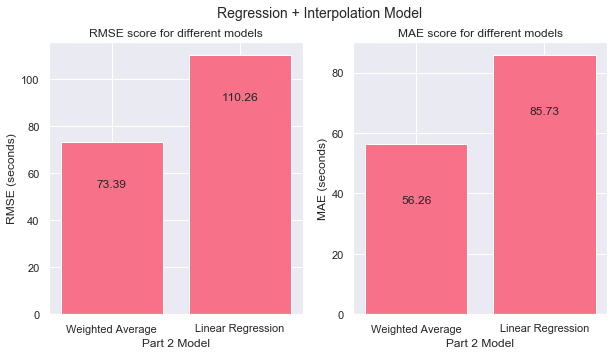

In [1423]:
model2_labels = ["Weighted Average", "Linear Regression"]

fig, ax = plt.subplots(figsize=(10,5), nrows = 1, ncols = 2)

ax[0].bar(model2_labels, [rmse_weighted_avg, rmse_line])
ax[0].set_title("RMSE score for different models")
ax[0].set_xlabel("Part 2 Model")
ax[0].set_ylabel("RMSE (seconds)")

rects_rmse = ax[0].patches
labels_rmsem = [round(rmse_weighted_avg, 2), round(rmse_line, 2)]

for rect, label in zip(rects_rmse, labels_rmsem):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 20, label,
            ha='center', va='bottom')
    
ax[1].bar(model2_labels, [mape_weighted_avg, mape_line])
ax[1].set_title("MAE score for different models")
ax[1].set_xlabel("Part 2 Model")
ax[1].set_ylabel("MAE (seconds)")

rects_mape = ax[1].patches
labels_mapem = [round(mape_weighted_avg, 2), round(mape_line, 2)]

for rect, label in zip(rects_mape, labels_mapem):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 20, label,
            ha='center', va='bottom')

fig.suptitle('Regression + Interpolation Model', fontsize=14)
plt.show()

In [1355]:
y_pred_best = best_alpha * (y_preds1_okehampton) + (1 - best_alpha) * (y_preds2_okehampton)

In [1373]:
tfl_predictions = pd.read_csv("data-collection/tfl preds/tfl_predictions.csv")

reduced_preds = tfl_predictions.loc[(tfl_predictions['start_stop'] == "Willesden Bus Garage") & (tfl_predictions['end_stop'] == "Okehampton Road")]
tfl_preds_52 = []

for x in reduced_preds['pred_jrny_time']:
    minutes = int(x[2:4])
    seconds = int(x[5:])
    tfl_preds_52.append(minutes + (seconds / 60))

tfl_times = [convert_time_to_datetime(x) for x in reduced_preds['time_of_req']]

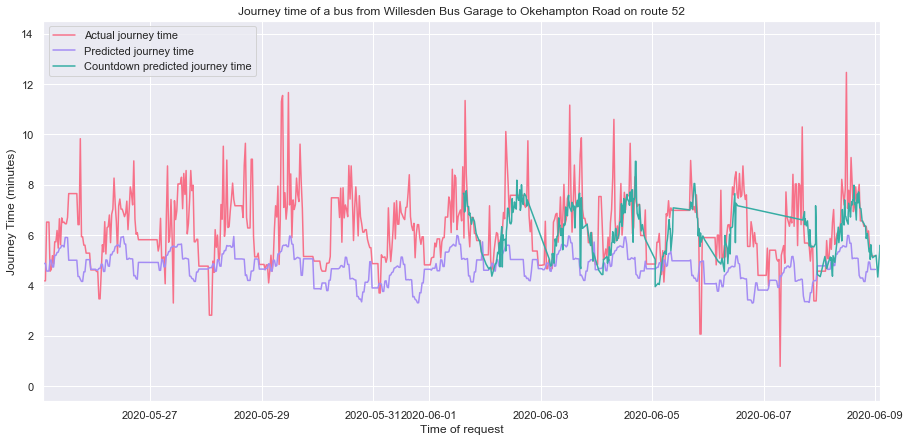

In [1372]:
times = [convert_time_to_datetime(t) for t in req_times]
y_acc_okehampton = [x / 60 for x in y_actual_okehampton]
y_pred_okehampton = [x / 60 for x in y_pred_best]

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(times, y_acc_okehampton, label="Actual journey time")
ax.plot(times, y_pred_okehampton, label="Predicted journey time", color=colours[6])
ax.plot(tfl_times, tfl_preds_52, label="Countdown predicted journey time", color=colours[4])
ax.set_xlabel("Time of request")
ax.set_ylabel("Journey Time (minutes)")
# ax.set_ylim(0, 15)
ax.set_xlim([dt.datetime(2020, 5, 25, 2), dt.datetime(2020, 6, 9, 2)])
ax.set_title("Journey time of a bus from Willesden Bus Garage to Okehampton Road on route 52")
ax.legend()

plt.show()

### Find the actual values to compare against the TfL predictions

In [1463]:
oke_temp = oke_temp.reset_index()

In [ ]:
tfl_req = reduced_preds['time_of_req']

route_data = pd.DataFrame()
for req_time in reduced_preds['time_of_req']:

    most_recent_left_index, last_x_buses, time_to_req = get_times_past_x_buses(oke_temp, req_time, 10)

#     print(most_recent_left_index)
    if most_recent_left_index <= 0:
        continue

    actual, _ = get_actual_times(most_recent_left_index, oke_temp)
    
    route_data = route_data.append(actual)

### Evidently, the weighted average model as the part 2 model is optimal

the best alpha is as below

In [ ]:
# Do part 1 prediction
part1_coeffs
part1_intercept

# Do part 2 prediction

In [ ]:
y_pred = best_alpha * (y_preds1) + (1 - alpha) * (y_preds2_weighted_avg)

#### CONCLUSIONS:



TODO: In this case, is MAPE or RMSE a better measure of success?
CONCLUSIONS?

In [1424]:
regression_mapes = [mape_weighted_avg, mape_line]
regression_rmses = [rmse_weighted_avg, rmse_line]

%store regression_mapes regression_rmses

Stored 'regression_mapes' (list)
Stored 'regression_rmses' (list)


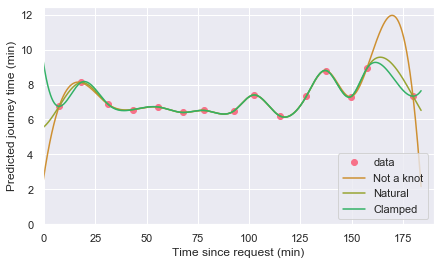

In [1148]:
x = np.arange(5,20)
y = range(5, 20)
xs = np.arange(-0.5, 20, 0.1)

def graph(degree):
    x_train = np.array(x).reshape(-1, 1)
    x_test = np.array(xs).reshape(-1, 1)
    y_train = np.array(y).reshape(-1, 1)

    poly = PolynomialFeatures(degree = degree)
    poly.fit(x_train)

    x_train = poly.transform(x_train)
    x_test = poly.transform(x_test)

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)
    
    pred = linreg.predict(x_test)
    return pred

def graph_weighted_avg(x):
    pred = 0
    sum_weights = 0
    weights = {"2": 0.45, "5": 0.3, "10": 0.2, "15": 0.05}
    
    for j in range(0, 15):
        weight = 0
        
        if (j < 2):
            weight = weights["2"]
        elif (j < 5) & (j >= 2):
            weight = weights["5"]
        elif (j < 10) & (j >= 5):
            weight = weights["10"]
        elif (j < 15) & (j >= 10):
            weight = weights["15"]
        
        journey_time = x[j]
        
        pred += weight * journey_time
        sum_weights += weight
    
    pred = pred / sum_weights
    return pred

temp = part2_df.iloc[792]
last_15 = temp.drop(columns=['Journey Time (s)'])

part2_x2 = []
part2_y2 = []

for i in range(0, 15):
    col1 = "Bus " + str(i)
    col2 = "Bus " + str(i) + " time to req"
    jrny = last_15[col1]
    time_to_req = last_15[col2]

    if math.isnan(jrny) or math.isnan(time_to_req):
        continue

    part2_y2.append(jrny)
    part2_x2.append(time_to_req)

x = [val / 60 for val in part2_x2]
y = [val / 60 for val in part2_y2]
cs1 = CubicSpline(x, y)
cs_nat1 = CubicSpline(x, y, bc_type='natural')
cs_clamped1 = CubicSpline(x, y, bc_type='clamped')

xs = np.arange(-0.5, 184, 0.1)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(xs, cs1(xs), label = "Not a knot")
ax.plot(xs, cs_nat1(xs), label = "Natural")
ax.plot(xs, cs_clamped1(xs), label = "Clamped")
ax.legend(loc='lower right')
ax.set_xlim(-0.5, 190)
ax.set_ylim(0)
ax.set_xlabel("Time since request (min)")
ax.set_ylabel("Predicted journey time (min)")
plt.show()

# fig, ax = plt.subplots(figsize=(6.5, 4))
# ax.plot(x, y, 'o', label='data')
# # ax.plot(xs, graph(1), label="degree = 1")
# # ax.plot(xs, graph(2), label="degree = 2")
# # ax.plot(xs, graph(3), label="degree = 3")
# ax.plot([-0.5, 20], [graph_weighted_avg(y), graph_weighted_avg(y)], label="weighted average")
# ax.set_xlim(-0.5, 20)
# ax.set_ylim(0, 20)
# ax.set_xlabel("Time since request (min)")
# ax.set_ylabel("Predicted journey time (min)")
# ax.legend(loc='lower right', ncol=2)
# plt.show()

# change the graph to get positive values on y axis